### Import Required Packagaes

In [62]:
import spacy
import pandas as pd
import re
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import Dataset, DataLoader

### Clean Review Texts

In [63]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

### Tokenization
This is for training the ML model.

In [64]:
nlp = spacy.load("en_core_web_sm")

def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_stop and not token.is_punct]

### All Caps Ratio
Some reviews may contain lots of capitalisation, indicating frustration. These could be rants or spam.

In [65]:
def all_caps_ratio(text):
    words = text.split()
    caps_words = [word for word in words if word.isupper()]
    return len(caps_words) / len(words) if len(words) > 0 else 0

### Sentiment Analysis - Relevancy Score
Analyse the emotions in each review. Very negative reviews could potentially be rants.

In [66]:
sentiment_analyzer = pipeline("sentiment-analysis")

def calculate_relevancy_score(text):
    # Can adjust this score based on sentiment, length, and keyword presence
    # For example, the higher the sentiment score and review length, the more relevant it is
    sentiment_score = sentiment_analyzer(text)[0]['score']
    review_length = len(text.split())
    caps_ratio = all_caps_ratio(text)
    
    # Simple heuristic: higher sentiment, longer review, lower caps_ratio = more trustworthy
    relevancy_score = (sentiment_score * 40) + (review_length * 0.5) - (caps_ratio * 20)
    return min(max(int(relevancy_score), 0), 100)  # Ensure the score is between 0 and 100

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


### Emotions Analysis
Trained roberta-base using goemotions dataset.


In [67]:
# -----------------------
# Load local model + tokenizer
# -----------------------

model_path = '../models/trained_model'

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_path,
    local_files_only=True,
    trust_remote_code=False
)

tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=model_path,
    local_files_only=True,
    trust_remote_code=False
)

# -----------------------
# Define labels (must match training)
# -----------------------
LABELS = [
    'admiration','amusement','anger','annoyance','approval','caring',
    'confusion','curiosity','desire','disappointment','disapproval','disgust',
    'embarrassment','excitement','fear','gratitude','grief','joy','love',
    'nervousness','optimism','pride','realization','relief','remorse',
    'sadness','surprise','neutral'
]

# -----------------------
# Dataset class for inference
# -----------------------
class InferenceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = str(self.dataframe.iloc[idx]['review_text'])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
        }

# -----------------------
# Inference function
# -----------------------
def get_predictions_for_dataframe(
    dataframe, model, tokenizer, batch_size=16, device=None,
    multi_label=True, threshold=0.5
):
    """
    Run inference on dataframe["text"] using model.
    
    multi_label=True  -> sigmoid + threshold (multi-label classification)
    multi_label=False -> softmax + argmax (single-label classification)
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    dataset = InferenceDataset(dataframe, tokenizer)
    loader = DataLoader(dataset, batch_size=batch_size)

    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            if multi_label:
                # multi-label: sigmoid + threshold
                probs = torch.sigmoid(logits)
                batch_predictions = (probs > threshold).int().cpu().tolist()
            else:
                # single-label: softmax + argmax
                probs = torch.softmax(logits, dim=-1)
                batch_predictions = torch.argmax(probs, dim=-1).cpu().tolist()

            predictions.extend(batch_predictions)

    if multi_label:
        # One column per label (0/1)
        predictions_df = pd.DataFrame(predictions, columns=LABELS)

        # Add human-readable labels
        readable_labels = []
        for row in predictions_df.values:
            active = [LABELS[i] for i, val in enumerate(row) if val == 1]
            readable_labels.append(", ".join(active) if active else "none")
        predictions_df["predicted_labels"] = readable_labels

        result_df = pd.concat([dataframe.reset_index(drop=True), predictions_df], axis=1)
    else:
        # Single-label: just map index -> label
        readable_labels = [LABELS[idx] for idx in predictions]
        result_df = dataframe.copy().reset_index(drop=True)
        result_df["predicted_label"] = readable_labels

    return result_df["predicted_labels"]


### Feature Engineering

In [68]:
def engineer_features(df):
    df['cleaned_review_text'] = df['review_text'].apply(clean_text)
    df['tokenized_review'] = df['cleaned_review_text'].apply(tokenize)
    df['review_length'] = df['tokenized_review'].apply(len)
    df['all_caps_ratio'] = df['review_text'].apply(all_caps_ratio)
    df['sentiment'] = df['cleaned_review_text'].apply(lambda x: sentiment_analyzer(x)[0]['label'])
    df['relevancy_score'] = df['review_text'].apply(calculate_relevancy_score)
    emotions = get_predictions_for_dataframe(df, model, tokenizer, multi_label=True)
    df["emotions"] = emotions
    return df

### Extract Features from Qwen and Hand-labelled Data

In [69]:
qwen_data_path = '../data/label/qwen_labelled_combined_reviews.csv'
qwen_df = pd.read_csv(qwen_data_path).copy()
qwen_feature_df = engineer_features(qwen_df)

hand_data_path = '../data/label/hand_labelled_combined_reviews.csv'
hand_df = pd.read_csv(hand_data_path).copy()
hand_feature_df = engineer_features(hand_df)


# Save the results to CSV files
qwen2_data_path = '../data/with_features/qwen_labelled_combined_reviews_with_features.csv'
qwen_feature_df.to_csv(qwen2_data_path, index=False)

hand2_data_path = '../data/with_features/hand_labelled_combined_reviews_with_features.csv'
hand_feature_df.to_csv(hand2_data_path, index=False)

In [70]:
qwen_feature_df

,user_name,review_text,rating,label,cleaned_review_text,tokenized_review,review_length,all_caps_ratio,sentiment,relevancy_score,emotions
0,Amber Thibeault,Andrea is amazing. Our dog loves her and she a...,5,Irrelevant,andrea is amazing our dog loves her and she al...,"[andrea, amazing, dog, loves, looks, amazing, ...",9,0.000000,POSITIVE,48,admiration
1,Esther,Andrea does a wonderful job with our wild Pr...,5,Irrelevant,andrea does a wonderful job with our wild pr...,"[andrea, wonderful, , job, , wild, princess,...",11,0.000000,POSITIVE,47,"admiration, gratitude"
2,Bob Barrett,Never called back,1,Rant,never called back,[called],1,0.000000,POSITIVE,41,neutral
3,Luz Quiles,They don't answer the phones,3,Rant,they dont answer the phones,"[nt, answer, phones]",3,0.000000,NEGATIVE,42,neutral
4,Tim Sanderson,Limited information on the website,3,Irrelevant,limited information on the website,"[limited, information, website]",3,0.000000,NEGATIVE,42,neutral
...,...,...,...,...,...,...,...,...,...,...,...
995,Kathy Perkins,Brett Williams is awesome!!!!,5,Irrelevant,brett williams is awesome,"[brett, williams, awesome]",3,0.000000,POSITIVE,41,admiration
996,Brett Smith,they have they the kinds of cars a teen will n...,5,Irrelevant,they have they the kinds of cars a teen will n...,"[kinds, cars, teen, need, start, diving, cars,...",9,0.000000,NEGATIVE,48,neutral
997,Tina Johnson,"I would not go back there for nothing, the gen...",1,Rant,i would not go back there for nothing the gent...,"[gentleman, told, come, extra, income, oh, owe...",10,0.043478,NEGATIVE,61,none
998,Craig Hoffmann,Awesome prices,5,Irrelevant,awesome prices,"[awesome, prices]",2,0.000000,POSITIVE,40,admiration


### Visualisations

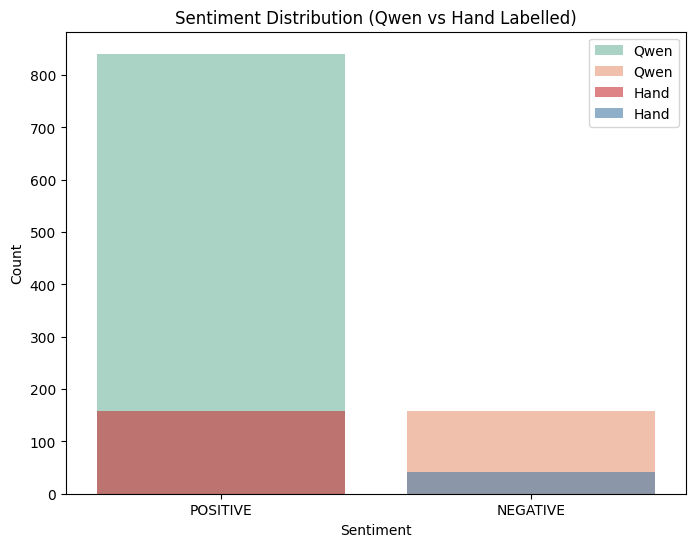

In [71]:
# Sentiment Distribution for Qwen and Hand-labelled datasets (Overlayed)
plt.figure(figsize=(8, 6))
sns.countplot(data=qwen_feature_df, x='sentiment', hue='sentiment', palette='Set2', label='Qwen', alpha=0.6)
sns.countplot(data=hand_feature_df, x='sentiment', hue='sentiment', palette='Set1', label='Hand', alpha=0.6)
plt.title('Sentiment Distribution (Qwen vs Hand Labelled)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend()
plt.show()


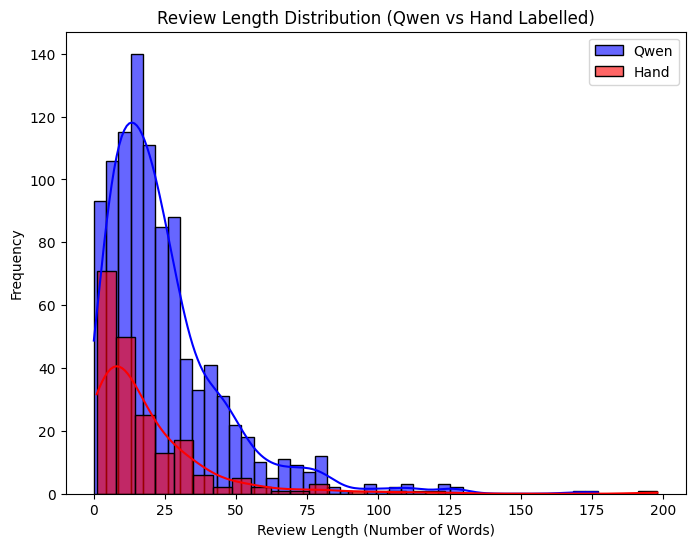

In [72]:
# Review Length Distribution for Qwen and Hand-labelled datasets (Overlayed)
plt.figure(figsize=(8, 6))
sns.histplot(qwen_feature_df['review_length'], kde=True, color='blue', label='Qwen', alpha=0.6)
sns.histplot(hand_feature_df['review_length'], kde=True, color='red', label='Hand', alpha=0.6)
plt.title('Review Length Distribution (Qwen vs Hand Labelled)')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

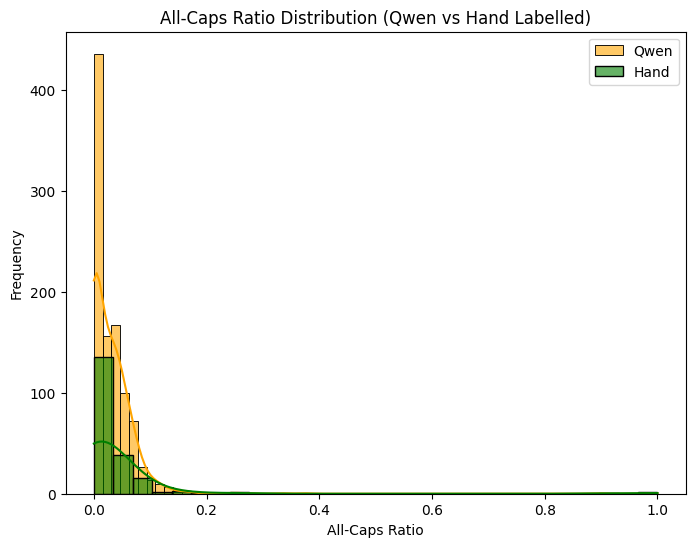

In [73]:
# All-Caps Ratio Distribution for Qwen and Hand-labelled datasets (Overlayed)
plt.figure(figsize=(8, 6))
sns.histplot(qwen_feature_df['all_caps_ratio'], kde=True, color='orange', label='Qwen', alpha=0.6)
sns.histplot(hand_feature_df['all_caps_ratio'], kde=True, color='green', label='Hand', alpha=0.6)
plt.title('All-Caps Ratio Distribution (Qwen vs Hand Labelled)')
plt.xlabel('All-Caps Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.show()

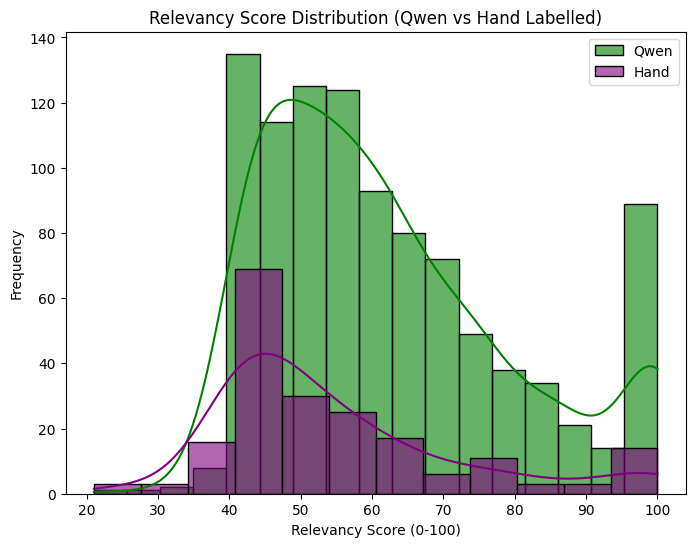

In [74]:
# Relevancy Score Distribution for Qwen and Hand-labelled datasets (Overlayed)
plt.figure(figsize=(8, 6))
sns.histplot(qwen_feature_df['relevancy_score'], kde=True, color='green', label='Qwen', alpha=0.6)
sns.histplot(hand_feature_df['relevancy_score'], kde=True, color='purple', label='Hand', alpha=0.6)
plt.title('Relevancy Score Distribution (Qwen vs Hand Labelled)')
plt.xlabel('Relevancy Score (0-100)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

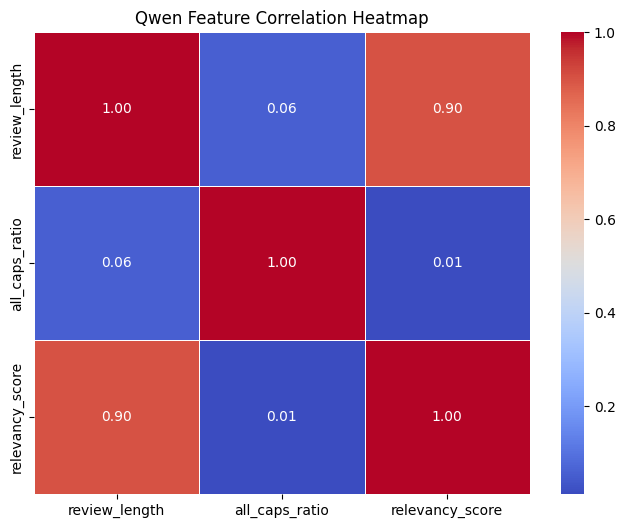

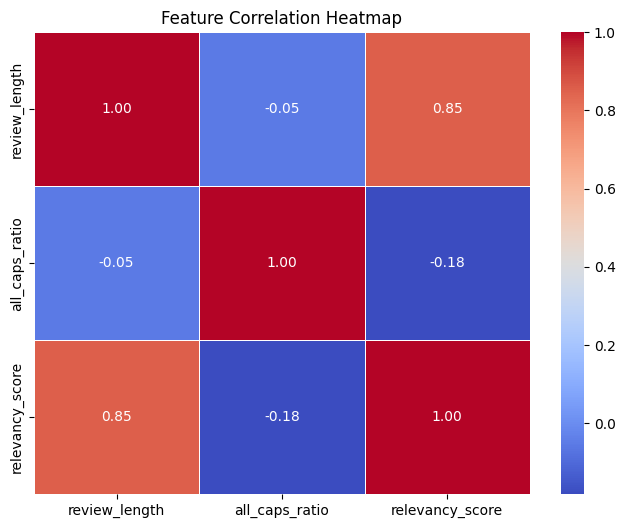

In [75]:
# Feature Correlation Heatmap for Qwen and Hand-labelled datasets
correlation_matrix = qwen_feature_df[['review_length', 'all_caps_ratio', 'relevancy_score']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Qwen Feature Correlation Heatmap')
plt.show()

correlation_matrix = hand_feature_df[['review_length', 'all_caps_ratio', 'relevancy_score']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()